# Project Three: 911 Dispatch

This is a project to predict the numbers of 911 dispatch between 2011-2014 and the year before.

 

In [27]:
import os
try:
    inputFunc = raw_input
except NameError:
    inputFunc = input

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
 
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import random



# Custom functions

def evaluate(pred, labels_test):
    acc = accuracy_score(pred, labels_test)
    print ("Accuracey: %s"%acc)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall = tp / (tp + fp)
    percision = tp / (tp + fn)
    f1 = (2 / ((1/recall)+(1/percision)))

    print ("")
    print ("True Negatives: %s"%tn)
    print ("False Positives: %s"%fp)
    print ("False Negatives: %s"%fn)
    print ("True Positives: %s"%tp)
    print ("Recall: %s"%recall)
    print ("Precision: %s"%percision)
    print ("F1 Score: %s"%f1)

def plot_bound(Z_val,data,col1,col2,binary):
    # Z-val equals "Yes" value. E.g., "Y" or "1". 
    # data equals df
    # col1 and col2 defines which colums to use from data
    # Plot binary decision boundary. 
    # For this, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    
    x_min = float(data.iloc[:,[col1]].min())-float(data.iloc[:,[col1]].min())*0.10 
    x_max = float(data.iloc[:,[col1]].max()+float(data.iloc[:,[col1]].min())*0.10)
    y_min = 0.0; 
    y_max = float(training.iloc[:,[col2]].max())+float(training.iloc[:,[col2]].max())*0.10
    h_x = (x_max-x_min)/100  # step size in the mesh
    h_y = (y_max-y_min)/100  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
    if binary == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   
        Z = np.where(Z=="Y",1,0)
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.pcolormesh(xx, yy, Z)
    plt.show()

## Data Cleaning

I cleaned this [911 Dispatch data](https://data.boston.gov/dataset/17129fad-fff9-4eac-ad74-51fb4bf63c22/resource/2459542e-7026-48e2-9128-ca29dd3bebf8/download/911-daily-dispatch-count-by-agency.csv). I got the data from [Analyze Boston](https://data.boston.gov/), a data hub of the City of Boston. The Dataset includes date, year, month, day of year and the amount of calls in total and separated by the Boston Police Department, Boston Fire Department, and Emergency Medical Services.

Here we load the data we collected and get it all ready to feed to our statistical model(s). That is, we are trying to make a table with one **target** column and one or more **features**. Here I'm loading happiness.csv from: https://data.somervillema.gov/Happiness/Somerville-Happiness-Survey-responses-2011-2013-20/w898-3dfm Note: you can find information on the data elements at this link. 


In [28]:
# Load and peek at your data. Change the file name as needed. 
raw_data_df = pd.read_csv('911.csv') 
raw_data_df.head()

,Year,Month,Total,BPD,BFD,EMS
0,2010,11,2603,1969,259,375
1,2010,11,2414,1852,206,356
2,2010,11,2487,1872,235,380
3,2010,11,2328,1695,241,392
4,2010,11,2478,1915,225,338


In [29]:
# You can count the number of rows like so
print("Size of entire table: %s "%len(raw_data_df))


Size of entire table: 1268 


In [30]:
# To make sure all of your columns are stored as numbers, use the pd.to_numeric method like so.
raw_data_df = raw_data_df.apply(pd.to_numeric, errors='coerce')
# errors='coerce' will set things that can't be converted to numbers to NaN
# so you'll want to drop these like so.
raw_data_df = raw_data_df.dropna()
raw_data_df.head()

,Year,Month,Total,BPD,BFD,EMS
0,2010,11,2603,1969,259,375
1,2010,11,2414,1852,206,356
2,2010,11,2487,1872,235,380
3,2010,11,2328,1695,241,392
4,2010,11,2478,1915,225,338


In [31]:
df = pd.DataFrame()
n = 0
for j in range(2010,2015):
    for i in range(1,13):
        #if (j == 2010 and i >= 11) or (j > 2010 and j < 2014) or (j == 2014 and i <= 4):
         if (j == 2011 and i >= 11) or (j > 2011 and j < 2014) or (j == 2014 and i <= 4):
            #print (j,i)
            data = pd.DataFrame([[
                                  i  ,
                                  raw_data_df[(raw_data_df["Year"]==j) & (raw_data_df["Month"]==i)]["Total"].sum(),
                                  raw_data_df[(raw_data_df["Year"]==j-1) & (raw_data_df["Month"]==i)]["Total"].sum(),
                                 ]],index=[n],columns=['Month','Total','Total_last_year'])
            df = df.append(data)
            n = n + 1

In [32]:
df

,Month,Total,Total_last_year
0,11,75215,69616
1,12,75360,68439
2,1,79309,72976
3,2,75746,68199
4,3,86160,75770
5,4,86512,73758
6,5,91985,81477
7,6,90120,78878
8,7,92775,84440
9,8,90869,82678


In [33]:
dispatch_lin_df = df[[
                               'Total', 
                               'Total_last_year'
                               ]].copy()
dispatch_lin_df

,Total,Total_last_year
0,75215,69616
1,75360,68439
2,79309,72976
3,75746,68199
4,86160,75770
5,86512,73758
6,91985,81477
7,90120,78878
8,92775,84440
9,90869,82678


## Taining and Validation

Above I created four datasets worth exploring: 
- **`happy_lin_df`**. The data needed to access *happiness* along a continuous variable.
- **`sat_lin_df`**. The data needed to access *satisfaction* along a continuous variable.
- **`happy_class_df`**. The data needed to access *happiness* as a categorical variable.
- **`sat_class_df`**. The data needed to access *satisfaction* as a categorical variable.

Let's take them each in turn. 

## dispatch_lin_df



In [54]:
data = dispatch_lin_df
holdout = data.sample(frac=0.3)
training = data.loc[~data.index.isin(holdout.index)]

In [55]:
training

,Total,Total_last_year
0,75215,69616
2,79309,72976
3,75746,68199
4,86160,75770
6,91985,81477
8,92775,84440
9,90869,82678
11,91572,82139
13,83461,75360
15,74466,75746


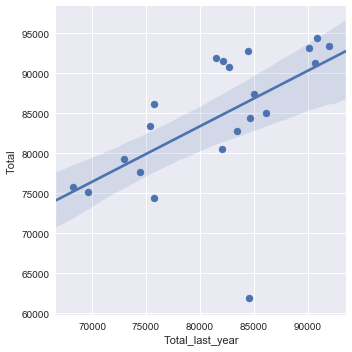

In [56]:
sns.lmplot(x="Total_last_year", y="Total", data=training, x_estimator=np.mean, order=1)

In [57]:
model = ols("Total ~ Total_last_year", training).fit()
#model = ols("Total ~ Month + np.power(Month, 2)", training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     9.583
Date:                Mon, 04 Dec 2017   Prob (F-statistic):            0.00595
Time:                        17:06:46   Log-Likelihood:                -214.60
No. Observations:                  21   AIC:                             433.2
Df Residuals:                      19   BIC:                             435.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.787e+04   1.83e+04      1.519      0.145   -1.05e+04    6.63e+04
Total_last_year     0.6941      0.224      3.096      0.006       0.225       1.163
==============================================================================
Omnibus:                       27.757   Durbin-Watson:                   0.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.239
Skew:                          -2.251   Prob(JB):                     4.53e-12
Kurtosis:                       9.279   Cond. No.                     9.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# Rerun with SciKitLearn because it's easy to check accuracy
features_train = training.drop("Total", axis=1).as_matrix(columns=None)
labels_train = training["Total"].as_matrix(columns=None)

features_test = holdout.drop("Total", axis=1).as_matrix(columns=None)
labels_test = holdout["Total"].as_matrix(columns=None)

lm = linear_model.LinearRegression()
clf = lm.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = metrics.r2_score(labels_test, pred)
print("R squared:",lm.score(features_train,labels_train))
print("Accuracy:",accuracy)

R squared: 0.335262514006
Accuracy: 0.35784054888
